In [2]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import trimesh
from datetime import datetime 

from pointnet2_utils import PointNetSetAbstractionMsg, PointNetSetAbstraction
from pointnet2_keypoint_regressor import get_model#, get_model_msg

from torch.utils.data import random_split

import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [5]:
class ShapeNetKeypointDataset(Dataset):
    def __init__(self, mesh_dir, annotation_json):
        self.mesh_dir = mesh_dir
        self.samples = []

        #count_valid = 0
        #count_total = 0

        # Load annotations
        with open(annotation_json) as f:
            annotations = json.load(f)

        for entry in annotations:
            model_id = entry['model_id']
            #print(model_id)
            keypoints = np.array([kp['xyz'] for kp in entry['keypoints']], dtype=np.float32)
            #count_total += 1
            if keypoints.shape[0] != NUM_KEYPOINTS:
                continue  # Strictly filter only 6-keypoint meshes
            self.samples.append((model_id, keypoints))
            #count_valid += 1

        #print(f"Total meshes: {count_total}, Valid 6-keypoint meshes: {count_valid}")
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        model_id, keypoints = self.samples[idx]

        #print("Inside __getitem__: keypoints.shape =", keypoints.shape) 

        mesh_path = os.path.join(self.mesh_dir, model_id + ".ply")

        try:
            mesh = trimesh.load(mesh_path, force='mesh')
            if mesh.is_empty or len(mesh.faces) == 0:
                raise ValueError("Empty mesh")

            points, _ = trimesh.sample.sample_surface(mesh, NUM_POINTS)
            if points.shape[0] < NUM_POINTS:
                pad_size = NUM_POINTS - points.shape[0]
                pad = np.repeat(points[0:1, :], pad_size, axis=0)
                points = np.vstack((points, pad))
        except Exception as e:
            print(f"Error loading mesh {model_id}: {e}")
            points = np.zeros((NUM_POINTS, 3), dtype=np.float32)
            keypoints = np.zeros((NUM_KEYPOINTS, 3), dtype=np.float32)

        # Normalize
        #print("Points Min:", np.min(points), "Max:", np.max(points))

        centroid = np.mean(points, axis=0)
        scale = np.max(np.linalg.norm(points - centroid, axis=1))
        points = (points - centroid) / scale
        keypoints = (keypoints - centroid) / scale


        return torch.from_numpy(points).float(), torch.from_numpy(keypoints).float()


In [6]:
NUM_POINTS = 1024 # Minimum 512 for input, ~1000 for neighborhood density; 2^14 = 16384
NUM_KEYPOINTS = 9 # 2 meshes have 5 keypoints idk why
BATCH_SIZE = 128

In [ ]:
# Training Loop

dataset = ShapeNetKeypointDataset(mesh_dir="Guitars/9_Augmented", annotation_json="guitar_9_augmented.json")  

total_size = len(dataset)
val_size = int(0.2 * total_size)
train_size = total_size - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

#dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(val_dataset)}")

train_losses = []
val_losses = []



#model = PointNetKeypointRegressor(NUM_KEYPOINTS).to(device)
model = get_model(num_keypoints=NUM_KEYPOINTS, normal_channel=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

start_epoch = 0

if False: # For resuming.
    os.makedirs("train_checkpoints", exist_ok=True)

    #resume_checkpoint_path = "saved_models/guitarnet_final.pth"
    resume_checkpoint_path = "train_checkpoints/guitarnet++_epoch_50.pth"
    if os.path.exists(resume_checkpoint_path):
        checkpoint = torch.load(resume_checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])

        print(f"Resuming training from epoch {start_epoch}")


total_epoch = 50 # Additional epochs to train 
for epoch in range(total_epoch):
    model.train()
    total_train_loss = 0
    #num_batches = 0
    
    for batch_idx, (pts, kps) in enumerate(train_loader):
        try:
            pts, kps = pts.to(device), kps.to(device)
            pts = pts.permute(0, 2, 1) #Permute to fit input size
            
            # Forward pass
            preds, _ = model(pts)
            loss = F.mse_loss(preds, kps)
            #loss = nn.MSELoss() # Not sure why this one is better tbh
            
            # Back pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accumulate loss
            total_train_loss += loss.item()
            #num_batches += 1
            
            #if epoch == 0 and batch_idx == 0:
            if batch_idx == 0:
                #print(f"First batch - Input shape: {pts.shape}, Target shape: {kps.shape}")
                #print(f"First batch loss: {loss.item():.6f}")
                print(f"Pred range: [{preds.min():.3f}, {preds.max():.3f}]")
                print(f"Target range: [{kps.min():.3f}, {kps.max():.3f}]")
            
        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            continue
    
    # Average train loss
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for pts, kps in val_loader:
            pts, kps = pts.to(device), kps.to(device)
            pts = pts.permute(0,2,1)
            preds, _ = model(pts)
            val_loss = F.mse_loss(preds, kps)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss/len(val_loader)
    val_losses.append(avg_val_loss)

    if True:
        if (epoch + start_epoch + 1) % 5 == 0:
                for param_group in optimizer.param_groups:
                    param_group['lr'] *= 0.8
                print("Force-reduced LR to 80%")

    if False:
        if epoch + start_epoch + 1 == 20:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-4
            print("Reduced LR to 1e-4")
    if False: #For checkpointing
        if (epoch + 1) % 10 == 0:
            checkpoint_path = f"train_checkpoints/guitarnet++_lin_3_epoch_{start_epoch + epoch+1}.pth"
            torch.save({
                'epoch': start_epoch + epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_train_loss,
                'train_losses': train_losses,
                'val_losses': val_losses
            }, checkpoint_path)
            print(f"Saved checkpoint: {checkpoint_path}")
    
    print(f"Epoch {epoch+ start_epoch + 1}/{start_epoch + total_epoch}\nTrain Loss: {avg_train_loss:.6f}; Validation Loss: {avg_val_loss:.6f}")
if False: #For save when done
    torch.save({
        'model_state_dict': model.state_dict(),
        'epoch': epoch,
        'loss': avg_train_loss,
        'config': {'num_keypoints': NUM_KEYPOINTS, 'num_points': NUM_POINTS}
    }, "saved_models/guitarnet++_lin_3_final.pth")

print("Training completed!")

Train dataset size: 2348
Test dataset size: 587
Pred range: [-0.562, 0.643]
Target range: [-1.006, 1.010]
Epoch 1/50
Train Loss: 0.061864; Validation Loss: 0.078836
Pred range: [-1.589, 1.309]
Target range: [-1.019, 1.024]
Epoch 2/50
Train Loss: 0.009446; Validation Loss: 0.076760
Pred range: [-1.165, 1.176]
Target range: [-1.004, 1.019]
Epoch 3/50
Train Loss: 0.005098; Validation Loss: 0.078935
Pred range: [-1.122, 1.128]
Target range: [-1.008, 1.017]
Epoch 4/50
Train Loss: 0.004269; Validation Loss: 0.006506
Pred range: [-1.094, 1.233]
Target range: [-1.000, 1.026]
Epoch 5/50
Train Loss: 0.004929; Validation Loss: 0.003952
Pred range: [-1.178, 1.042]
Target range: [-1.002, 1.058]
Epoch 6/50
Train Loss: 0.003864; Validation Loss: 0.003656
Pred range: [-0.999, 0.992]
Target range: [-1.014, 1.022]
Epoch 7/50
Train Loss: 0.003378; Validation Loss: 0.003265
Pred range: [-1.072, 1.074]
Target range: [-1.008, 1.045]
Epoch 8/50
Train Loss: 0.003724; Validation Loss: 0.003114
Pred range: [-1.

In [11]:
torch.save({
    'model_state_dict': model.state_dict(),
    'epoch': epoch,
    'loss': [avg_train_loss, avg_val_loss],
    'config': {'num_keypoints': NUM_KEYPOINTS, 'num_points': NUM_POINTS}
}, "saved_models/guitarnet++_lin_4_final.pth")

In [12]:
class KeypointPredictor:
    def __init__(self, model_path, device='cuda'):
        """
        Initialize the keypoint predictor
        
        Args:
            model_path: path to saved model (.pth file)
            device: 'cuda' or 'cpu'
        """
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        
        # Load model checkpoint
        checkpoint = torch.load(model_path, map_location=self.device)
        self.config = checkpoint.get('config', {'num_keypoints': 9, 'num_points': 1024})
        
        # Initialize model
        self.model = get_model(
            num_keypoints=self.config['num_keypoints'], 
            normal_channel=False
        ).to(self.device)
        
        # Load trained weights
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()
        
        print(f"Loaded model with {self.config['num_keypoints']} keypoints")
        print(f"Using device: {self.device}")
    
    def load_and_sample_mesh(self, mesh_path, num_points=None):
        """
        Load mesh and sample points from surface
        
        Args:
            mesh_path: path to mesh file (.ply, .obj, etc.)
            num_points: number of points to sample (default: from config)
        
        Returns:
            points: numpy array of shape (num_points, 3)
        """
        if num_points is None:
            num_points = self.config['num_points']
        
        try:
            # Load mesh
            mesh = trimesh.load(mesh_path, force='mesh')
            if mesh.is_empty or len(mesh.faces) == 0:
                raise ValueError("Empty mesh")
            
            # Sample points from surface
            points, _ = trimesh.sample.sample_surface(mesh, num_points)
            
            # Handle case where mesh has fewer faces than requested points
            if points.shape[0] < num_points:
                pad_size = num_points - points.shape[0]
                pad = np.repeat(points[0:1, :], pad_size, axis=0)
                points = np.vstack((points, pad))
            
            return points.astype(np.float32)
            
        except Exception as e:
            print(f"Error loading mesh {mesh_path}: {e}")
            return None
    
    def normalize_points(self, points):
        """
        Normalize points using same method as training
        
        Args:
            points: numpy array of shape (num_points, 3)
        
        Returns:
            normalized_points: numpy array of shape (num_points, 3)
            centroid: numpy array of shape (3,) - for denormalization
            scale: float - for denormalization
        """
        centroid = np.mean(points, axis=0)
        scale = np.max(np.linalg.norm(points - centroid, axis=1))
        
        # Avoid division by zero
        if scale == 0:
            scale = 1.0
        
        normalized_points = (points - centroid) / scale
        return normalized_points, centroid, scale
    
    def denormalize_keypoints(self, keypoints, centroid, scale):
        """
        Convert normalized keypoints back to original coordinate system
        
        Args:
            keypoints: numpy array of shape (num_keypoints, 3)
            centroid: numpy array of shape (3,)
            scale: float
        
        Returns:
            denormalized_keypoints: numpy array of shape (num_keypoints, 3)
        """
        return keypoints * scale + centroid
    
    def predict_keypoints(self, mesh_path, return_normalized=False):
        """
        Predict keypoints for a single mesh
        
        Args:
            mesh_path: path to mesh file
            return_normalized: if True, return keypoints in normalized coordinates
        
        Returns:
            keypoints: numpy array of shape (num_keypoints, 3)
            points: numpy array of shape (num_points, 3) - sampled points
            metadata: dict with normalization info
        """
        # Load and sample mesh
        points = self.load_and_sample_mesh(mesh_path)
        if points is None:
            return None, None, None
        
        # Normalize points
        normalized_points, centroid, scale = self.normalize_points(points)
        
        # Convert to tensor and add batch dimension
        points_tensor = torch.from_numpy(normalized_points).float()
        points_tensor = points_tensor.unsqueeze(0).permute(0, 2, 1).to(self.device)  # Shape: (1, 3, num_points)
        
        # Predict keypoints
        with torch.no_grad():
            predicted_keypoints, _ = self.model(points_tensor)
        
        # Convert back to numpy
        predicted_keypoints = predicted_keypoints.squeeze(0).cpu().numpy()  # Shape: (num_keypoints, 3)
        
        # Denormalize if requested
        if not return_normalized:
            predicted_keypoints = self.denormalize_keypoints(predicted_keypoints, centroid, scale)
            points_for_vis = points  # Original points
        else:
            points_for_vis = normalized_points
        
        metadata = {
            'centroid': centroid,
            'scale': scale,
            'mesh_path': mesh_path
        }
        
        return predicted_keypoints, points_for_vis, metadata
    
    def predict_batch(self, mesh_paths, return_normalized=False):
        """
        Predict keypoints for multiple meshes
        
        Args:
            mesh_paths: list of paths to mesh files
            return_normalized: if True, return keypoints in normalized coordinates
        
        Returns:
            results: list of (keypoints, points, metadata) tuples
        """
        results = []
        for mesh_path in mesh_paths:
            result = self.predict_keypoints(mesh_path, return_normalized)
            results.append(result)
        return results




In [13]:
def save_keypoints_to_file(keypoints, output_path, mesh_path=None):
    """
    Save keypoints to a text file
    
    Args:
        keypoints: numpy array of shape (num_keypoints, 3)
        output_path: path to save keypoints
        mesh_path: original mesh path (for reference)
    """
    with open(output_path, 'w') as f:
        if mesh_path:
            f.write(f"# Keypoints for mesh: {mesh_path}\n")
        f.write(f"# Format: x y z\n")
        f.write(f"# Number of keypoints: {len(keypoints)}\n")
        
        for i, kp in enumerate(keypoints):
            f.write(f"{kp[0]:.6f} {kp[1]:.6f} {kp[2]:.6f}\n")
    
    print(f"Keypoints saved to: {output_path}")

In [38]:
def visualize_keypoints_3d(points, keypoints, title="Predicted Keypoints", figsize=(12, 8)):
    """
    Visualize point cloud with predicted keypoints
    
    Args:
        points: numpy array of shape (num_points, 3)
        keypoints: numpy array of shape (num_keypoints, 3)
        title: string
        figsize: tuple for figure size
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot point cloud
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], 
               c='lightblue', alpha=0.6, s=1, label='Point Cloud')
    
    # Plot keypoints
    ax.scatter(keypoints[:, 0], keypoints[:, 1], keypoints[:, 2], 
               c='red', s=100, label='Predicted Keypoints', marker='o')
    
    # Add keypoint numbers
    for i, kp in enumerate(keypoints):
        ax.text(kp[0], kp[1], kp[2], f'  {i}', fontsize=10)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    
    # Set equal aspect ratio
    max_range = np.array([points[:, 0].max()-points[:, 0].min(),
                         points[:, 1].max()-points[:, 1].min(),
                         points[:, 2].max()-points[:, 2].min()]).max() / 2.0
    mid_x = (points[:, 0].max()+points[:, 0].min()) * 0.5
    mid_y = (points[:, 1].max()+points[:, 1].min()) * 0.5
    mid_z = (points[:, 2].max()+points[:, 2].min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.view_init(elev=-90, azim=90)
    
    plt.show()



Loaded model with 9 keypoints
Using device: cuda
Predicted 9 keypoints for Guitars/9_points/feab270427cee00a24eeca91f583600.ply
Keypoints coordinates:
0.018 0.265 0.010
0.000 -0.331 -0.018
0.081 -0.236 -0.012
-0.094 -0.331 -0.005
0.085 -0.591 -0.009
-0.115 -0.612 -0.005
-0.016 -0.624 -0.004
0.085 -0.427 0.003
-0.096 -0.434 -0.007


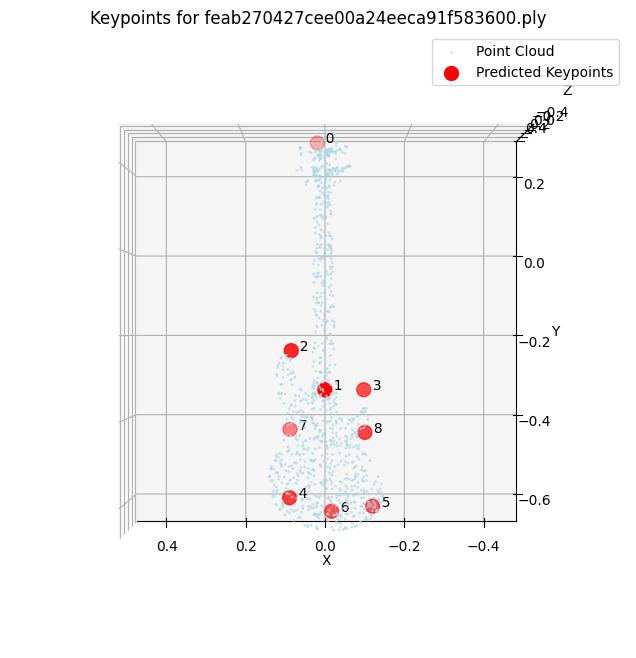

In [39]:
predictor = KeypointPredictor("saved_models/guitarnet++_lin_4_final.pth")

save = False

# Predict keypoints for a single mesh
mesh_path = "Guitars/9_points/feab270427cee00a24eeca91f583600.ply" 
keypoints, points, metadata = predictor.predict_keypoints(mesh_path)

if keypoints is not None:
    print(f"Predicted {len(keypoints)} keypoints for {mesh_path}")
    print("Keypoints coordinates:")
    for i, kp in enumerate(keypoints):
        print(f"{kp[0]:.3f} {kp[1]:.3f} {kp[2]:.3f}")
    
    # Visualize results
    visualize_keypoints_3d(points, keypoints, f"Keypoints for {os.path.basename(mesh_path)}")
    
    # Save keypoints to file
    if save:
        output_path = mesh_path.replace('.ply', '_keypoints.txt')
        save_keypoints_to_file(keypoints, output_path, mesh_path)
else:
    print(f"Failed to process {mesh_path}")



In [ ]:
# Example 2: Batch prediction
def example_batch_prediction():
    predictor = KeypointPredictor("saved_models/guitarnet++_lin_4_final.pth")
    
    # List of mesh files to process
    mesh_directory = "path/to/mesh/directory"  # Replace with actual directory
    mesh_files = [f for f in os.listdir(mesh_directory) if f.endswith('.ply')]
    mesh_paths = [os.path.join(mesh_directory, f) for f in mesh_files[:5]]  # Process first 5
    
    # Predict for all meshes
    results = predictor.predict_batch(mesh_paths)
    
    for i, (keypoints, points, metadata) in enumerate(results):
        if keypoints is not None:
            print(f"Mesh {i+1}: {os.path.basename(metadata['mesh_path'])}")
            print(f"  Predicted {len(keypoints)} keypoints")
            
            # Visualize (optional - comment out if too many meshes)
            if i < 3:  # Only show first 3
                visualize_keypoints_3d(points, keypoints, f"Mesh {i+1}")



In [ ]:
# Example 3: Interactive prediction function
def predict_and_visualize(mesh_path, model_path="saved_models/guitarnet++_lin_4_final.pth"):
    """
    Convenient function to predict and visualize keypoints for any mesh
    
    Args:
        mesh_path: path to mesh file
        model_path: path to trained model
    """
    predictor = KeypointPredictor(model_path)
    keypoints, points, metadata = predictor.predict_keypoints(mesh_path)
    
    if keypoints is not None:
        print(f"Successfully predicted keypoints for {os.path.basename(mesh_path)}")
        visualize_keypoints_3d(points, keypoints, f"Keypoints: {os.path.basename(mesh_path)}")
        return keypoints, points, metadata
    else:
        print(f"Failed to process {mesh_path}")
        return None, None, None

# ===== RUN EXAMPLES =====
# Uncomment the lines below to test:

# Example usage - replace with your actual mesh path:
# keypoints, points, metadata = predict_and_visualize("path/to/your/guitar.ply")

# Or use the more detailed examples:
# example_single_prediction()
# example_batch_prediction()